# Snake Charge Scan

To manipulate an electron confined in a gate-defined quantum dot, it is essential to control the number of electrons i.e. the chemical potential of each quantum dot and the tunnel coupling among quantum dots. The charge stability diagram (CSD) shows changes in the electron occupation of the system in response to changes in applied gate voltages. This information can be used to extract the operation point for further experiments. For an infinitely slow gate sweep and in absence of charging effects the CSD shows the charge occupation of the ground state. In the real world however, the CSD can depend on the sweep direction of gate voltages and a charge state hysteresis in quantum dots has been observed and investigated. [1]

[1] C. H. Yang, et al., Appl. Phys. Lett. 105, 183505 (2014)

In this tutorial, a pulse for the bi-directional sweep of a CSD is constructed so that the hysteresis of charge occupancy in a double quantum dot system can be measured. For ease of analysis, 2 different measurement windows namingly `('x_neg', 'x_pos')` are defined providing the possibliy of inspecting two sweep direction individually. Options of `plot` function in `qupulse.pulses.plotting` will be explored as well.

## Create a linear voltage sweep

The basic building block of any such a diagram is a linear sweep of a channel. The first thing we need to do is write such a sweep. There are two options to implement this on a conceptional level.

The first is to interpret the sweep as a continuous change of the voltage in time. The number of points here is just determined by the time resolution of our readout. Each readout point represents an average over a short time window of this continuous sweep.

The second approach is to change the applied voltage in a fixed number of steps. Here the number of points is already a property of the pulse and each readout point is the average over the output at that point.

In the following we will explore both variants and their hardware feasibility.

### Continuous voltage sweep

Let us first explore the first option. We can use a `TablePT` or a `PointPT` to implement it.

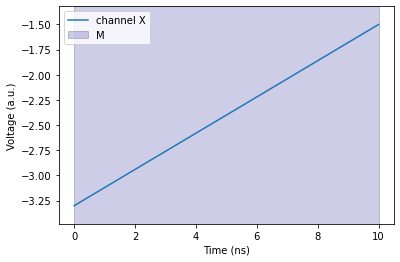

In [1]:
import matplotlib.pyplot as plt

from qupulse.pulses import *
from qupulse.plotting import *

linear_cont = TablePT({'X': [(0, 'x_start'),
                             ('tx_sweep', 'x_stop', 'linear')]},
                      measurements=[('M', 0, 'tx_sweep')])

x_sweep_params = {'x_start': -3.3, 'x_stop': -1.5, 'tx_sweep': 10.}

_ = plot(linear_cont, parameters=x_sweep_params, stepped=False, plot_measurements={'M'})

You'll notice that this pulse does only have one measurement window over the whole range attached. For a sweep with `n` points we would maybe expect `n` measurement windows. However, measurement windows require a pulse template to be attached to and there is no way in qupulse (yet in 2023) to change or parameterize the number of measurement windows directly. You have to change the number of pulse template instantiations f.i. with a `RepetitionPT` or a `ForLoopPT` to change the number of measurement windows.

We can however interpret the measurement window as the time window where the sweep happens and use it as such in our measurement configuration and data analysis. qupulse does not enforce or promote a particular meaning of measurement windows. qupulse simply tracks them through complex pulse trees and gives you their final position in an instantiated pulse.

### Stepped sweep

Next we will explore how to write a "stepped" sweep. We want the number of steps to be parameterized by `n_x` and the range by `x_start` and `x_stop`. The total duration of the sweep shall  be `tx_sweep`.

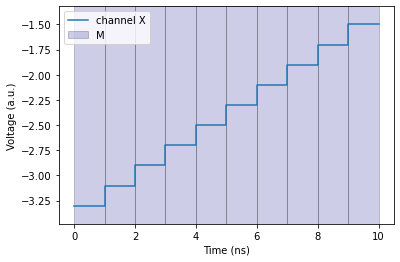

In [2]:
step = ConstantPT(duration='tx_sweep / n_x', amplitude_dict={'X': 'x_start + x_i * (x_stop - x_start) / (n_x - 1)'},
                  measurements=[('M', 0, 'tx_sweep / n_x')])

# equivalent to ForLoopPT(step, 'x_i', 'n_x')
linear_step = step.with_iteration('x_i', 'n_x')

x_sweep_params.update(n_x=10)

_ = plot(linear_step, parameters=x_sweep_params, plot_measurements={'M'})

Here we see that each step has its own measurement window.

## The snake: going forward and backward

We can now utilize the `TimeReversalPT` to go backward and combine both direction with a `SequencePT`. Furthermore, we want to rename the measurement windows to discriminate between forward and backward measurements. We can utilize the `with_*` methods and the overloaded matrix multiplication operator `@` to make this very concise.

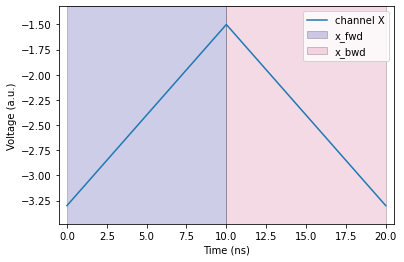

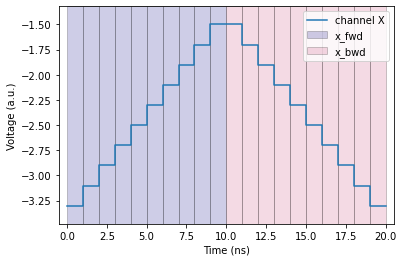

In [3]:
snake_1d_cont = linear_cont.with_mapping({'M': 'x_fwd'}) @ linear_cont.with_time_reversal().with_mapping({'M': 'x_bwd'})
snake_1d_step = linear_step.with_mapping({'M': 'x_fwd'}) @ linear_step.with_time_reversal().with_mapping({'M': 'x_bwd'})

_ = plot(snake_1d_cont, parameters=x_sweep_params, plot_measurements={'x_fwd', 'x_bwd'}, stepped=False)
_ = plot(snake_1d_step, parameters=x_sweep_params, plot_measurements={'x_fwd', 'x_bwd'})

## Two-dimensional sweep

The next step is to make two-dimensional scans. We need to add the `Y` channel and loop over the desired voltages. We can use the `ParallelChannelPT` and `ForLoopPT` for that. The number of points in y-direction shall be `n_y`.

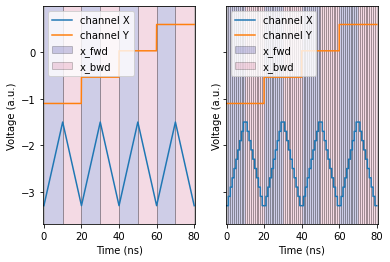

In [4]:
y_value = {'Y': 'y_start + y_i * (y_stop - y_start) / (n_y - 1)'}

# with_* methods
snake_step = snake_1d_step\
    .with_parallel_channels(y_value)\
    .with_iteration('y_i', 'n_y')

# Direct class instantiation
snake_linear = ForLoopPT(ParallelChannelPT(snake_1d_cont, y_value), 'y_i', 'n_y')

sweep_params_2d = {**x_sweep_params, 'y_start': -1.1, 'y_stop': 0.6, 'n_y': 4}

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
_ = plot(snake_linear, parameters=sweep_params_2d, plot_measurements={'x_fwd', 'x_bwd'}, stepped=False, axes=ax1)
_ = plot(snake_step, parameters=sweep_params_2d, plot_measurements={'x_fwd', 'x_bwd'}, axes=ax2)

Now that we created a two-dimensional scan we can use the `plot_2d` function to inspect what it does in voltage space i.e. without a time axis and compare it to a regular "forward only" charge scan. First we create that one from the `linear_step` sweep defined above.

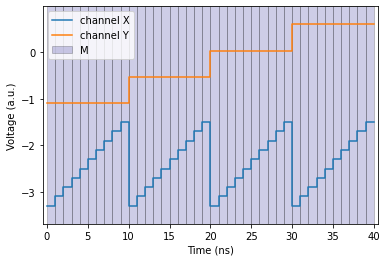

In [5]:
chrg_scan = ForLoopPT(ParallelChannelPT(linear_step, y_value), 'y_i', 'n_y')

_ = plot(chrg_scan, parameters=sweep_params_2d, plot_measurements={'M'})
default_params = {
    'n_segments': 2,
    'x_start': 0,
    'x_stop': 3,
    'y_start': 0,
    'y_stop': 2,
    'N_x': 10,
    'N_y': 5,
    'sample_rate': 1,
    'cds_res': 5
}

Now, we use `plot` function to inspect the positive sweep of channel X which is highlighted in the following plot.

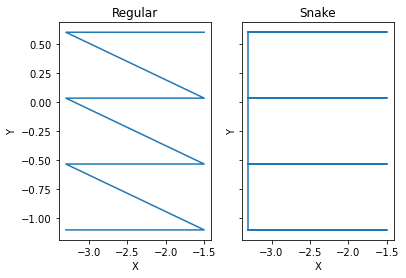

In [6]:
from qupulse.plotting import plot_2d

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Regular")
ax2.set_title("Snake")
_ =  plot_2d(chrg_scan, ('X', 'Y'), parameters=sweep_params_2d, ax=ax1)
_ =  plot_2d(snake_step, ('X', 'Y'), parameters=sweep_params_2d, ax=ax2)

## Benchmark

When we try to instantiate such a pulse it will take some time but not severe yet. However, a typical charge scan has a higher resolution. The qupulse parameter evaluation machinery can become a bottleneck here since it is run for every of the 100 points. There is work being done on optimizing it so see for yourself what the current status is.

In [7]:
import timeit

# Try with different resolution by yourself!
exp_params = {
    'tx_sweep': 10240,
    'x_start': -50e-3,
    'x_stop': 50e-3,
    'y_start': 0,
    'y_stop': 0.1,              
    'n_x': 100,                 # voltage resolution: 1 mV
    'n_y': 100,                 # voltage resolution: 1 mV
}


# using arbitary parameters for simplicity.
simple_inst = timeit.timeit(lambda: snake_step.create_program(parameters=sweep_params_2d), number=1)
print(f'Elapsed time: {simple_inst} seconds')

# in a real experiment:
exp_inst = timeit.timeit(lambda: snake_step.create_program(parameters=exp_params), number=1)
print(f'Elapsed time: {exp_inst} seconds')

Elapsed time: 0.008839400000000275 seconds


Elapsed time: 1.7463892000000003 seconds


## Hardware limitations and legacy pulses

This section is under construction and will give an example and reasoning why old pulses often contain

`RepetitionPT(ConstantPT(...))`

and how this was superseeded by the `qupulse._program._loop.roll_constant_waveforms` function.